In [4]:
import datetime as dt
import numpy as np
import pandas as pd

from Pandora.helper import TDays
from Pandora.research.backtest import CODES_SHORT, calc_sharpe, COMMISSION
from vnpy.trader.constant import Interval, Product
from vnpy.trader.optimize import OptimizationSetting
from vnpy.trader.setting import SETTINGS
from logging import INFO
from vnpy.app.vnpy_portfoliostrategy import BacktestingEngine

SETTINGS["log.active"] = True
SETTINGS["log.level"] = INFO
SETTINGS["log.console"] = True



In [5]:
def get_mc(codes):
    from vnpy.trader.database import get_database

    database = get_database()
    today = dt.datetime.combine(TDays.get_tday(fmt=None, end_hour=23), dt.time(0))
    contracts = database.load_contract_data(product=Product.FUTURES, start=today, end=today)
    mc = [i for i in contracts if i.symbol.endswith('00') and i.product_id in codes]

    return mc


## DataLoading

In [6]:
from Pandora.research import CODES_MM

mc = get_mc(CODES_SHORT)

engine = BacktestingEngine()
engine.contracts = {i.vt_symbol: i for i in mc}

engine.set_parameters(
    vt_symbols=[i.vt_symbol for i in mc],
    interval=Interval.MINUTE_15,
    start=dt.datetime(2015, 1, 1),
    end=dt.datetime.now(),
    rates={
        i.vt_symbol: COMMISSION for i in mc
    },
    slippages={
        i.vt_symbol: 0 for i in mc
    },
    sizes={
        i.vt_symbol: i.size for i in mc
    },
    priceticks={
        i.vt_symbol: i.pricetick for i in mc
    },
    capital=1e8,
)

engine.load_data()



2024-07-10 14:34:29.980764	开始加载历史数据
2024-07-10 14:34:30.283963	AP00.CZCE历史数据加载完成，数据量：23790
2024-07-10 14:34:30.464021	CJ00.CZCE历史数据加载完成，数据量：18885
2024-07-10 14:34:30.894857	FG00.CZCE历史数据加载完成，数据量：53493
2024-07-10 14:34:31.299885	MA00.CZCE历史数据加载完成，数据量：54523
2024-07-10 14:34:31.504338	PF00.CZCE历史数据加载完成，数据量：20707
2024-07-10 14:34:31.609058	PK00.CZCE历史数据加载完成，数据量：12450
2024-07-10 14:34:31.845425	SA00.CZCE历史数据加载完成，数据量：24823
2024-07-10 14:34:32.276777	TA00.CZCE历史数据加载完成，数据量：54523
2024-07-10 14:34:32.420393	UR00.CZCE历史数据加载完成，数据量：17850
2024-07-10 14:34:33.031866	ag00.SHFE历史数据加载完成，数据量：82787
2024-07-10 14:34:33.559516	al00.SHFE历史数据加载完成，数据量：69671
2024-07-10 14:34:34.107075	cu00.SHFE历史数据加载完成，数据量：69671
2024-07-10 14:34:34.292579	eb00.DCE历史数据加载完成，数据量：25867
2024-07-10 14:34:34.621712	eg00.DCE历史数据加载完成，数据量：29744
2024-07-10 14:34:34.985246	hc00.SHFE历史数据加载完成，数据量：54679
2024-07-10 14:34:35.482937	i00.DCE历史数据加载完成，数据量：55137
2024-07-10 14:34:35.859928	j00.DCE历史数据加载完成，数据量：55137
2024-07-10 14:34:36.227452	jm00.DCE

## StrategyClass

In [4]:
from typing import List, Dict
from datetime import datetime, time

import numpy as np
import pandas as pd
import talib

from vnpy.app.vnpy_portfoliostrategy.base import EngineType
from vnpy.trader.setting import SETTINGS
from vnpy.trader.utility import ArrayManager
from vnpy.trader.object import TickData, BarData
from vnpy.trader.constant import Direction, Interval

from vnpy.app.vnpy_portfoliostrategy import StrategyTemplate, StrategyEngine
from vnpy.app.vnpy_portfoliostrategy.utility import PortfolioBarGenerator, ATRExitHelper


class TSStrategy(StrategyTemplate):
    author = "XCX"

    capital = 1e8
    interval = Interval.MINUTE_15

    window = 400

    atr_multiplier = 11

    vol_window = 100
    vol_target = 0.45
    vol_exit = True

    bband_width = 2
    stm_width = 0.8

    ls_imba = .75

    trade_method = "BBAND"

    parameters = [
        "capital",
        "window",

        "atr_multiplier",

        "vol_window",
        "vol_target",
        "vol_exit",

        "bband_width",
        "stm_width",

        "ls_imba",

        "trade_method",
    ]
    variables = [
    ]

    def __init__(
            self,
            strategy_engine: StrategyEngine,
            strategy_name: str,
            vt_symbols: List[str],
            setting: dict
    ) -> None:
        """构造函数"""
        super().__init__(strategy_engine, strategy_name, vt_symbols, setting)

        self.am_size = self.bband_window = self.atr_window = self.ma_window = self.stm_window = self.window
        self._trade_method = None

        self.prepare_trade()

        # 创建每个合约的ArrayManager
        self.ams: Dict[str, ArrayManager] = {}

        self.atr_helpers: Dict[str, ATRExitHelper] = {}
        for vt_symbol in self.vt_symbols:
            self.ams[vt_symbol] = ArrayManager(self.am_size)
            self.atr_helpers[vt_symbol] = ATRExitHelper(self.ams[vt_symbol])

        self.pbg = PortfolioBarGenerator(None, Interval.to_window(self.interval), self.on_bars)
        self.pbg.on_bars = self.pbg.update_bars

        if self.get_engine_type() == EngineType.SIGNAL:
            self.pos_data = self.target_data

    def prepare_trade(self):
        if self.trade_method == "BBAND":
            self.bband_window = self.window
            self.am_size = self.bband_window * 3 + max(self.window, self.atr_window, self.vol_window) * 3 + 100
            self._trade_method = self.trade_by_bband

        elif self.trade_method == "STM":
            self.stm_window = self.window
            self.am_size = self.stm_window * 3 + max(self.window, self.atr_window, self.vol_window) * 3 + 100
            self._trade_method = self.trade_by_stm

        elif self.trade_method == "CROSS":
            self.am_size = max(self.window, self.atr_window, self.vol_window) * 3 + 100
            self._trade_method = self.trade_by_cross

        elif self.trade_method == "CROSS_MA":
            self.am_size = self.ma_window * 3 + max(self.window, self.atr_window, self.vol_window) * 3 + 100
            self._trade_method = self.trade_by_cross_ma

        else:
            raise NotImplementedError(f"Unknown trade method {self.trade_method}")

    def on_init(self) -> None:
        """策略初始化回调"""
        self.write_log("策略初始化")

        if self.interval == Interval.MINUTE_15:
            days = int(self.am_size / 23) * 2  # mult 2 to fit trade day num, may fix in the future

        else:
            raise NotImplementedError

        self.load_bars(days, self.interval)

    def on_start(self) -> None:
        """策略启动回调"""
        self.write_log("策略启动")

        self.update_portfolio()

    def on_stop(self) -> None:
        """策略停止回调"""
        self.update_portfolio()

        self.write_log("策略停止")

    def on_tick(self, tick: TickData) -> None:
        """行情推送回调"""
        self.pbg.update_tick(tick)

    def on_bars(self, bars: Dict[str, BarData]) -> None:
        """K线切片回调"""
        super().on_bars(bars)

        for vt_symbol in self.vt_symbols:
            if vt_symbol in bars:
                bar = bars[vt_symbol]

                if (
                        bar.datetime.time() < time(9)  # 滤掉早盘集合竞价
                        or bar.datetime.time() >= time(23)  # 滤掉深夜交易
                        # or (time(21) > bar.datetime.time() >= time(20, 45))  # 滤掉夜盘集合竞价
                ):
                    return

                am: ArrayManager = self.ams[vt_symbol]
                am.update_bar(bar)

                self.atr_helpers[vt_symbol].on_bar(bar)

        if not self.trading:
            return

        self.update_portfolio()

        engine_type = self.get_engine_type()
        if engine_type != EngineType.SIGNAL:
            self.rebalance_portfolio(bars)

        self.put_event()

    def update_portfolio(self):
        for vt_symbol, am in self.ams.items():
            if not am.inited:
                continue

            atr_helper = self.atr_helpers[vt_symbol]
            current_pos = self.get_pos(vt_symbol)

            std = self.get_volatility(am)

            # if current_pos == 0:
            if self.vol_exit and std > self.vol_target:
                self.set_target(vt_symbol, 0)
                atr_helper.reset()

                continue

            direction = self.get_signal(am)
            if current_pos == 0 and direction == Direction.LONG:
                target_size = self.get_target_size_by_std_minus(vt_symbol, self.vol_window, std_max=self.vol_target)

                self.set_target(vt_symbol, target_size)

                atr_helper.on_target(self.last_prices[vt_symbol], Direction.LONG)

            elif current_pos == 0 and direction == Direction.SHORT:
                target_size = self.get_target_size_by_std_minus(vt_symbol, self.vol_window, std_max=self.vol_target)

                self.set_target(vt_symbol, -target_size)

                atr_helper.on_target(self.last_prices[vt_symbol], Direction.SHORT)

            else:
                if (
                        (current_pos > 0 and atr_helper.check_stoploss(self.atr_window, self.atr_multiplier))
                        or (current_pos < 0 and atr_helper.check_stoploss(self.atr_window, self.atr_multiplier * self.ls_imba))
                        # or atr_helper.check_stoploss(self.atr_window, self.atr_multiplier)
                ):
                    self.set_target(vt_symbol, 0)
                    atr_helper.reset()

        engine_type = self.get_engine_type()
        if engine_type != EngineType.BACKTESTING:
            self.save_strategy_portfolio()

    def get_factor(self, am: ArrayManager):
        factor, _, _ = am.macd(self.window, int(self.window / 12 * 26), int(self.window / 12 * 9), array=True)

        # _, factor, _ = am.macd(self.window, int(self.window / 12 * 26), int(self.window / 12 * 9), array=True)
        # factor = am.argmin(self.window, array=True)

        factor = talib.LINEARREG(factor, self.window)

        return factor

    def get_volatility(self, am: ArrayManager):
        roc = am.roc(1, True)
        std = np.std(np.log(1 + roc / 100)[-self.vol_window:]) * np.sqrt(252 * 23)

        return std

    def get_signal(self, am: ArrayManager):
        return self._trade_method(am)

    # def calculate_price(self, vt_symbol: str, direction: Direction, reference: float) -> float:
    #     """计算调仓委托价格（支持按需重载实现）"""
    #     if direction == Direction.LONG:
    #         price: float = reference + self.get_pricetick(vt_symbol) * 0
    #     else:
    #         price: float = reference - self.get_pricetick(vt_symbol) * 0
    #
    #     return price

    def save_strategy_portfolio(
            self,
            account_name: str = SETTINGS["account.name"],
            investor_id: str = SETTINGS["account.investorid"],
    ):
        print("Dev Stage, No save")

    def trade_by_stm(self, am: ArrayManager):
        factor = self.get_factor(am)

        hh = factor[-self.stm_window:].max()
        ll = factor[-self.stm_window:].min()

        stm = (factor * 2 - (hh + ll)) / (hh - ll)

        stm_upper = self.stm_width
        stm_lower = - self.stm_width * self.ls_imba

        if stm[-1] > stm_upper > stm[-2]:
            direction = Direction.LONG

        elif stm[-1] < stm_lower < stm[-2]:
            direction = Direction.SHORT

        else:
            direction = None

        return direction

    def trade_by_cross(self, am: ArrayManager):
        factor = self.get_factor(am)

        if factor[-1] > 0 > factor[-2]:
            direction = Direction.LONG

        elif factor[-1] < 0 < factor[-2]:
            direction = Direction.SHORT

        else:
            direction = None

        return direction

    def trade_by_cross_ma(self, am: ArrayManager):
        factor = self.get_factor(am)

        ma = factor[-self.ma_window:].mean()

        if factor[-1] > ma > factor[-2]:
            direction = Direction.LONG

        elif factor[-1] < ma < factor[-2]:
            direction = Direction.SHORT

        else:
            direction = None

        return direction

    def trade_by_bband(self, am: ArrayManager):
        factor = self.get_factor(am)

        factor_value = factor[-1]
        prev_value = factor[-2]

        bband_mid = factor[-self.bband_window:].mean()
        bband_width = factor[-self.bband_window:].std()

        if factor_value > bband_mid + self.bband_width * bband_width > prev_value:
            direction = Direction.LONG

        elif factor_value < bband_mid - self.bband_width * bband_width * self.ls_imba < prev_value:
            direction = Direction.SHORT

        else:
            direction = None

        return direction

    def get_target_size_by_std_minus(self, vt_symbol: str, param=500, day_count=23, n=3, std_min=0.1, std_max=0.45) -> int:
        am = self.ams[vt_symbol]

        roc = am.roc(1, True)
        weight = np.std(np.log(1 + roc / 100)[-param:]) * np.sqrt(252 * day_count)

        weight = ((std_max - weight) / (std_max - std_min) * (n - 1) + 1) / n
        weight = min(max(weight, 1 / n), 1)

        weight *= 1 / len([i for i in self.ams.values() if i.inited])

        size = int(self.capital * weight / self.get_size(vt_symbol) / am.close[-1])

        return size


## Backtest

2024-07-11 09:26:09.635963	策略初始化完成
2024-07-11 09:26:09.655909	开始回放历史数据


回放历史数据:   0%|          | 0/71325 [00:00<?, ?it/s]

2024-07-11 09:50:28.688472	历史数据回放结束
2024-07-11 09:50:28.689469	开始计算逐日盯市盈亏
2024-07-11 09:50:28.802168	逐日盯市盈亏计算完成
2024-07-11 09:50:28.802168	开始计算策略统计指标
2024-07-11 09:50:28.810146	------------------------------
2024-07-11 09:50:28.810146	首个交易日：	2016-04-21
2024-07-11 09:50:28.810146	最后交易日：	2024-07-09
2024-07-11 09:50:28.810146	总交易日：	2352
2024-07-11 09:50:28.810146	盈利交易日：	1209
2024-07-11 09:50:28.810146	亏损交易日：	1132
2024-07-11 09:50:28.810146	起始资金：	100,000,000.00
2024-07-11 09:50:28.810146	结束资金：	160,027,535.27
2024-07-11 09:50:28.810146	总收益率：	60.03%
2024-07-11 09:50:28.810146	年化收益：	6.43%
2024-07-11 09:50:28.810146	最大回撤: 	-4,235,245.79
2024-07-11 09:50:28.810146	百分比最大回撤: -4.03%
2024-07-11 09:50:28.810146	最长回撤天数: 	85
2024-07-11 09:50:28.810146	总盈亏：	60,027,535.27
2024-07-11 09:50:28.810146	总手续费：	3,842,082.98
2024-07-11 09:50:28.810146	总滑点：	0.00
2024-07-11 09:50:28.810146	总成交金额：	19,210,414,881.74
2024-07-11 09:50:28.810146	总成交笔数：	5233
2024-07-11 09:50:28.810146	日均盈亏：	25,521.91
2024-07-11 09:50:2

1.386771882990663

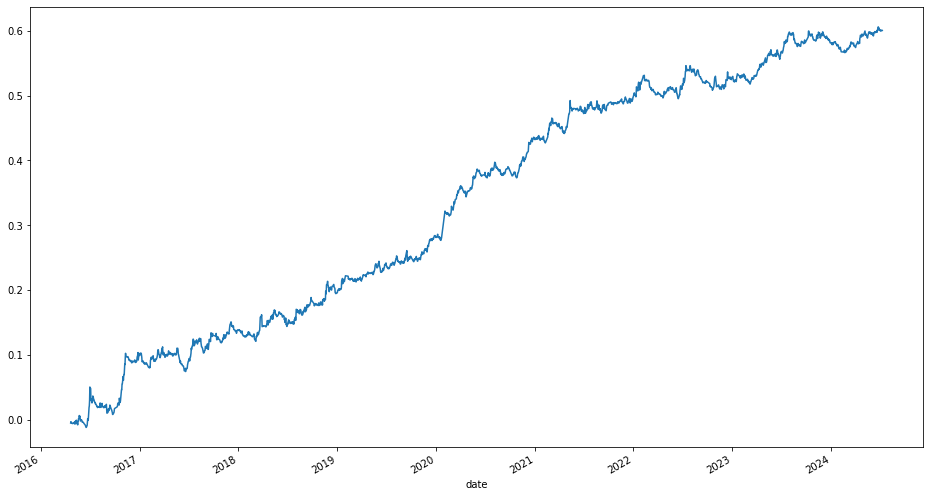

In [14]:
from vnpy.app.vnpy_portfoliostrategy.strategies.stm_strategy import STMStrategy

engine.clear_data()
setting = {
    "window": 700,
    "vol_exit": 1,
}
engine.add_strategy(STMStrategy, setting)

engine.run_backtesting()
df = engine.calculate_result()
engine.calculate_statistics()

daily_base = pd.Series(df['net_pnl'] / engine.capital, index=pd.to_datetime(df.index))
daily_base.cumsum().plot(figsize=(16, 9))
calc_sharpe(daily_base)

In [15]:
desc, rounds = engine.describe_trades()
desc

,hp,pnl,hp_long,pnl_long,hp_short,pnl_short
count,2611.000000,2611.000000,1364.000000,1364.000000,1247.000000,1247.000000
mean,13.491714,0.006325,13.267366,0.011642,13.737111,0.000509
std,13.071522,0.050568,13.152876,0.053305,12.982782,0.046727
min,0.010417,-0.126517,0.010417,-0.124600,0.010417,-0.126517
25%,3.432292,-0.023244,3.184896,-0.020119,3.598958,-0.027183
50%,8.208333,-0.006517,7.979167,-0.003713,8.947917,-0.010840
75%,21.020833,0.024399,20.921875,0.030590,21.328125,0.018210
max,81.479167,0.325879,81.010417,0.325879,81.479167,0.269553


In [17]:
rounds.sort_values('open_time')

,symbol,direction,open_time,open_price,close_time,close_price,volume,pnl,hp
0,hc00,Direction.LONG,2016-04-21 09:15:00+08:00,3165.0,2016-04-21 21:15:00+08:00,3130.0,125,-0.011058,0.5
0,TA00,Direction.LONG,2016-04-21 09:30:00+08:00,5170.0,2016-04-21 22:15:00+08:00,5022.0,204,-0.028627,0.53125
0,rb00,Direction.LONG,2016-04-21 13:45:00+08:00,1749.0,2016-04-21 21:15:00+08:00,1694.0,235,-0.031447,0.3125
0,al00,Direction.LONG,2016-04-21 14:15:00+08:00,9310.0,2016-04-21 22:00:00+08:00,9116.788699,142,-0.020753,0.322917
0,cu00,Direction.LONG,2016-04-21 14:15:00+08:00,47156.802166,2016-04-27 21:45:00+08:00,46106.126365,26,-0.02228,6.3125
...,...,...,...,...,...,...,...,...,...
133,TA00,Direction.LONG,2024-06-20 10:30:00+08:00,5933.745259,2024-07-04 23:00:00+08:00,5999.542837,134,0.011089,14.520833
140,j00,Direction.SHORT,2024-06-21 14:15:00+08:00,4273.068719,2024-07-01 11:00:00+08:00,4383.076084,6,-0.025744,9.864583
137,ag00,Direction.SHORT,2024-06-24 10:45:00+08:00,5391.138689,2024-07-05 14:15:00+08:00,5593.0,21,-0.037443,11.145833
67,AP00,Direction.SHORT,2024-06-25 10:30:00+08:00,6934.975357,2024-06-26 10:45:00+08:00,6951.0,46,-0.002311,1.010417


## Optimization

In [6]:
from vnpy.app.vnpy_portfoliostrategy.strategies.ts_strategy import TSStrategy as TSStrategy_

In [10]:
setting = {
    "window": 50,
}
engine.clear_data()
engine.add_strategy(STMStrategy, setting)


setting = OptimizationSetting()
setting.set_target("sharpe_ratio")
setting.add_parameter("window", 300, 1000, 100)
setting.add_parameter("vol_exit", 0, 1, 1)

opt_res = engine.run_bf_optimization(setting, max_workers=8)

sharpe_mat = pd.DataFrame()

for res in opt_res:
    param = res[0]
    sharpe = res[1]

    sharpe_mat.loc[param['window'], param['atr_multiplier']] = sharpe

sharpe_mat.sort_index().sort_index(axis=1)

2024-07-10 15:05:16.241650	开始执行穷举算法优化
2024-07-10 15:05:16.241650	参数优化空间：16


100%|██████████| 16/16 [1:05:28<00:00, 245.56s/it]


2024-07-10 16:10:48.980506	穷举算法优化完成，耗时3932秒
2024-07-10 16:10:52.137992	参数：{'window': 700, 'vol_exit': 1}, 目标：1.379147281261951
2024-07-10 16:10:52.138989	参数：{'window': 500, 'vol_exit': 1}, 目标：1.3550064525042567
2024-07-10 16:10:52.138989	参数：{'window': 700, 'vol_exit': 0}, 目标：1.3271789612384997
2024-07-10 16:10:52.138989	参数：{'window': 600, 'vol_exit': 1}, 目标：1.3162894510285859
2024-07-10 16:10:52.138989	参数：{'window': 900, 'vol_exit': 1}, 目标：1.2832935964067917
2024-07-10 16:10:52.138989	参数：{'window': 800, 'vol_exit': 1}, 目标：1.2286325389798123
2024-07-10 16:10:52.138989	参数：{'window': 500, 'vol_exit': 0}, 目标：1.1848199500926497
2024-07-10 16:10:52.138989	参数：{'window': 600, 'vol_exit': 0}, 目标：1.1504636797962746
2024-07-10 16:10:52.138989	参数：{'window': 900, 'vol_exit': 0}, 目标：1.130484912813807
2024-07-10 16:10:52.138989	参数：{'window': 800, 'vol_exit': 0}, 目标：1.1168183788679693
2024-07-10 16:10:52.138989	参数：{'window': 400, 'vol_exit': 1}, 目标：1.0400240021983582
2024-07-10 16:10:52.138989	参数：{'wi

KeyError: 'atr_multiplier'

In [11]:
sharpe_mat = pd.DataFrame()

for res in opt_res:
    param = res[0]
    sharpe = res[1]

    sharpe_mat.loc[param['window'], param['vol_exit']] = sharpe

sharpe_mat.sort_index().sort_index(axis=1)

,0,1
300,0.647450,0.798008
400,0.853083,1.040024
500,1.184820,1.355006
600,1.150464,1.316289
700,1.327179,1.379147
800,1.116818,1.228633
900,1.130485,1.283294
1000,0.874109,1.019208


## Param Selected

In [13]:
windows = [500, 700, 900,]
vol_exits = [0, 1]

navs = {}
for window in windows:
    for vol_exit in vol_exits:
        setting = {
            "window": window,
            "vol_exit": vol_exit,
        }
        
        engine.clear_data()
        engine.add_strategy(STMStrategy, setting)

        engine.run_backtesting()
        df = engine.calculate_result()
        
        daily_base = pd.Series(df['net_pnl'] / engine.capital, index=pd.to_datetime(df.index))
        navs[(window, atr_multiplier)] = daily_base
        
selected_nav = pd.DataFrame(navs)
selected_nav.cumsum().plot(figsize=(16, 9))

2024-07-11 09:03:45.986919	策略初始化完成
2024-07-11 09:03:46.022823	开始回放历史数据


回放历史数据:   0%|          | 0/74552 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Correlation

In [11]:
from Pandora.data_manager import get_api

api = get_api()

info = api.get_backtest_info()
loc = (info['StrategyName'] == 'STM') & (info['BackTestId'].str.contains('Trace'))
info.loc[loc, 'StrategyName'] = 'STM_Trace'

info

,BackTestId,StrategyName,TargetVol,Weight,Params,UpdateTime
0,Argmin_500-MM-CrossMA_11,ArgminCrossMA,0.05,0.055578,"{'window': 500, 'atr_multiplier': 11, 'ls_imba...",2024-07-08 20:48:36.843
1,Argmin_500-MM-CrossMA_11_LSImba_0.75,ArgminCrossMA,0.05,0.053110,"{'window': 500, 'atr_multiplier': 11, 'ls_imba...",2024-07-08 20:48:36.840
2,Argmin_500-SHORT-CrossMA_11,ArgminCrossMA,0.05,0.047289,"{'window': 500, 'atr_multiplier': 11, 'ls_imba...",2024-07-08 20:43:28.827
3,Argmin_500-SHORT-CrossMA_11_LSImba_0.75,ArgminCrossMA,0.05,0.045110,"{'window': 500, 'atr_multiplier': 11, 'ls_imba...",2024-07-08 20:43:28.820
4,Argmin_500-SHORT-CrossMA_13,ArgminCrossMA,0.05,0.045175,"{'window': 500, 'atr_multiplier': 13, 'ls_imba...",2024-07-08 20:43:28.830
...,...,...,...,...,...,...
621,WILLR_STM_V0_260_240-MA_240-TradeByCS_TMB_5_5,WILLR_STM,0.05,0.046074,"{'ma_window': 240, 'rebal': 5, 'n_group': 5}",2024-07-08 20:07:22.133
622,WILLR_STM_V0_280_220-MA_220-TradeByCS_TMB_5_5,WILLR_STM,0.05,0.045438,"{'ma_window': 220, 'rebal': 5, 'n_group': 5}",2024-07-08 20:07:22.137
623,WILLR_STM_V0_300_180-MA_180-TradeByCS_TMB_5_5,WILLR_STM,0.05,0.045022,"{'ma_window': 180, 'rebal': 5, 'n_group': 5}",2024-07-08 20:07:22.140
624,WILLR_STM_V0_300_200-MA_200-TradeByCS_TMB_5_5,WILLR_STM,0.05,0.045044,"{'ma_window': 200, 'rebal': 5, 'n_group': 5}",2024-07-08 20:07:22.140


In [12]:
info['StrategyName'].unique()

array(['ArgminCrossMA', 'BasisMom', 'Close', 'CpvCorr', 'CpvTsrank',
       'MACDSTM', 'MACDBBand', 'MOM_STM', 'NsSlope', 'OlsMtRes', 'PSARK',
       'RollYield', 'Rotary', 'STM_BIAS', 'STM_Trace', 'STM', 'WILLR_STM'],
      dtype=object)

In [13]:
strategies = [
    'ArgminCrossMA', 'Close', 'MACDBBand', 'MACDSTM', 'PSARK', 'STM', 'STM_Trace',
    'MOM_STM', 'STM_BIAS', 'WILLR_STM',
    'NsSlope', 'OlsMtRes', 'RollYield', 
    # 'Rotary'
]

In [14]:
import pandas as pd

strategy_nav = {}
for name, group in info.groupby('StrategyName'):
    if name not in strategies:
        continue
    
    navs = {}
    for i in group.index:
        id_ = group.loc[i, 'BackTestId']
        df = api.get_backtest_ret(id_)
        
        navs[id_] = df.set_index('DateTime')['Ret']
        
    
    strategy_nav[name] = pd.DataFrame(navs).mean(axis=1)
 

In [15]:
strategy_nav['tsstrategy'] = selected_nav.mean(axis=1)

In [16]:
pd.DataFrame(strategy_nav).fillna(0).corr()

,ArgminCrossMA,Close,MACDBBand,MACDSTM,MOM_STM,NsSlope,OlsMtRes,PSARK,RollYield,STM,STM_BIAS,STM_Trace,WILLR_STM,tsstrategy
ArgminCrossMA,1.000000,0.328754,0.748858,0.710056,0.007970,0.012084,0.027020,0.467620,-0.030863,0.550821,-0.036362,0.403236,0.008977,0.708080
Close,0.328754,1.000000,0.241172,0.268588,-0.010269,0.000735,-0.001922,0.845508,-0.013597,0.539348,0.025585,0.791383,-0.012858,0.220652
MACDBBand,0.748858,0.241172,1.000000,0.926747,0.031472,0.033542,0.044327,0.425979,-0.006612,0.522878,-0.032137,0.336405,0.026926,0.916859
MACDSTM,0.710056,0.268588,0.926747,1.000000,0.030627,0.044024,0.058148,0.441613,0.011768,0.506557,-0.027363,0.372164,0.034113,0.849011
MOM_STM,0.007970,-0.010269,0.031472,0.030627,1.000000,0.211964,0.098550,-0.008948,0.225553,-0.002078,0.637470,-0.001327,0.793752,0.034902
NsSlope,0.012084,0.000735,0.033542,0.044024,0.211964,1.000000,0.653903,-0.001079,0.778247,-0.009003,0.323552,0.008936,0.389431,0.031332
OlsMtRes,0.027020,-0.001922,0.044327,0.058148,0.098550,0.653903,1.000000,0.013869,0.544641,0.024820,0.189904,0.018560,0.263571,0.043056
PSARK,0.467620,0.845508,0.425979,0.441613,-0.008948,-0.001079,0.013869,1.000000,-0.024262,0.651056,-0.001986,0.814224,-0.014990,0.389179
RollYield,-0.030863,-0.013597,-0.006612,0.011768,0.225553,0.778247,0.544641,-0.024262,1.000000,-0.076933,0.467899,-0.016034,0.489244,-0.005051
STM,0.550821,0.539348,0.522878,0.506557,-0.002078,-0.009003,0.024820,0.651056,-0.076933,1.000000,-0.035849,0.626156,-0.027718,0.491646


<AxesSubplot:>

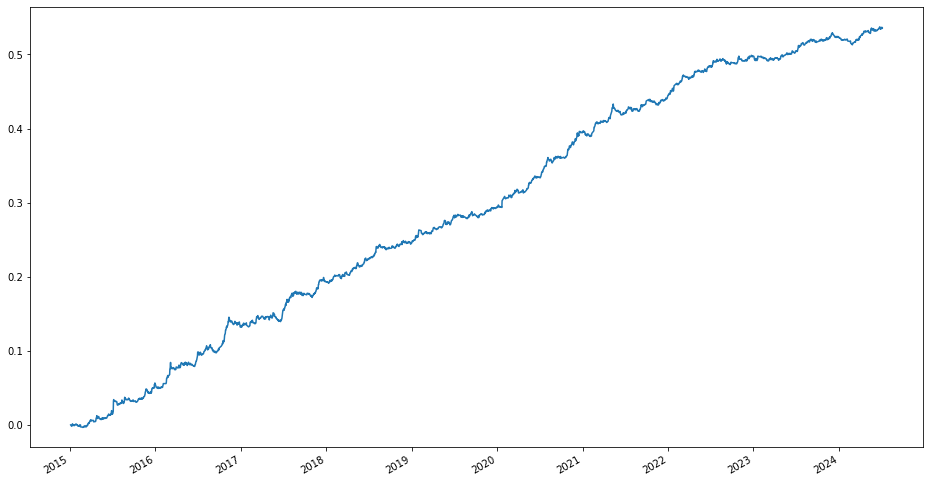

In [18]:
pd.DataFrame(strategy_nav).fillna(0).mean(axis=1).cumsum().plot(figsize=(16, 9))

<AxesSubplot:>

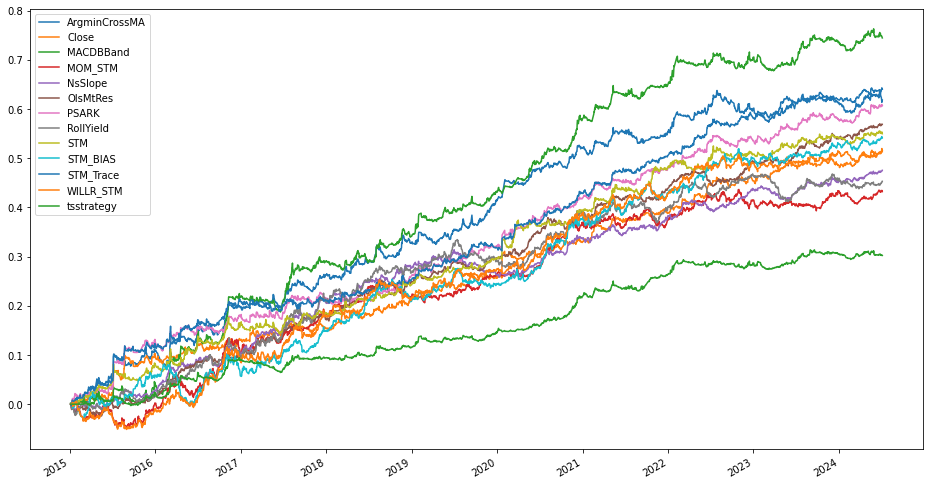

In [19]:
pd.DataFrame(strategy_nav).fillna(0).cumsum().plot(figsize=(16, 9))